<a href="https://colab.research.google.com/github/mukamal/deep-learning-object-recognition/blob/main/deep_learning_object_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object recognition with deep learning

If running on Google colab, the following cell installs pyspark

In [ ]:
# if running on Google colab
if 'google.colab' in str(get_ipython()):
  !pip install pyspark

Load preliminary packages and launch a Spark connection

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import subprocess
from pyspark.sql import SparkSession
import glob

spark = SparkSession.builder.master("local").appName("MLP Demo").config("spark.master", "local[*]").getOrCreate()
sc = spark.sparkContext

%matplotlib inline

# Utility Functions
Define a utility functions needed to display images.

In [ ]:
# utility function to display the first element of a Spark dataframe as an image
def display_first_as_img(df):
    plt.imshow(df.first().raw_pixels.toArray().reshape([60,40]), 'gray', aspect=0.5);
    display()

# Read the data

If running on Google colab, the following cell prompts the user to upload the credit score data file.

In [ ]:
# read the data file
# if running on Google Colab
if 'google.colab' in str(get_ipython()):
  # ask the user to upload the file
  from google.colab import files
  files.upload()

Saving caltech.parq to caltech.parq


In [ ]:
# load the file
caltech101_df = spark.read.parquet('caltech.parq')

The dataframe contains images from the [Caltech 101 dataset](https://www.vision.caltech.edu/Image_Datasets/Caltech101/). These images have been downsized and transformed to gray scale. Let's look at the content of the dataset:

In [ ]:
caltech101_df.printSchema()

root
 |-- category: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- raw_pixels: array (nullable = true)
 |    |-- element: double (containsNull = true)



The following cells convert the pixel arrays into dense vectors to be compatible with spark maching learning.

In [ ]:
catltech_rdd = caltech101_df.rdd

In [ ]:
caltech101_df = catltech_rdd.map(lambda x: (x[0],x[1],DenseVector(x[2]),)).toDF(['category','filename','raw_pixels'])

The column `raw_pixels` contains a flattened version of the 60 by 40 images. The dataset has 101 categories plus 1  distracting category:

In [ ]:
caltech101_df.select(fn.countDistinct('category')).show()

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                     102|
+------------------------+



The number of examples for each category is not balanced. For example the _airplanes_ and _motorbikes_ categories have nearly 10 times more examples than kangaroo and starfish:

In [ ]:
caltech101_df.groupby('category').agg(fn.count('*').alias('n_images')).orderBy(fn.desc('n_images')).show()

+-----------------+--------+
|         category|n_images|
+-----------------+--------+
|        airplanes|     800|
|       Motorbikes|     798|
|BACKGROUND_Google|     468|
|       Faces_easy|     435|
|            Faces|     435|
|            watch|     239|
|         Leopards|     200|
|           bonsai|     128|
|         car_side|     123|
|            ketch|     114|
|       chandelier|     107|
|        hawksbill|     100|
|      grand_piano|      99|
|            brain|      98|
|        butterfly|      91|
|       helicopter|      88|
|          menorah|      87|
|         starfish|      86|
|        trilobite|      86|
|         kangaroo|      86|
+-----------------+--------+
only showing top 20 rows



We will use the helper function `display_first_as_img` to display some images on the notebook. This function takes the first row of the dataframe and displays the `raw_pixels` as an image.

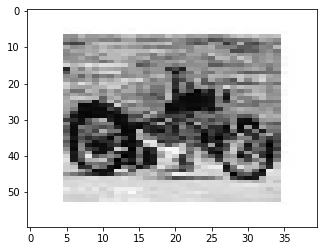

In [ ]:
display_first_as_img(caltech101_df.where(fn.col('category') == "Motorbikes").sample(True, 0.1))

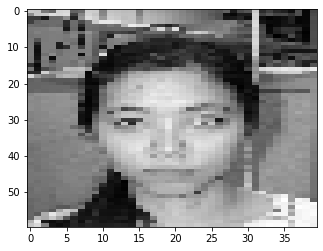

In [ ]:
display_first_as_img(caltech101_df.where(fn.col('category') == "Faces_easy").sample(True, 0.5))

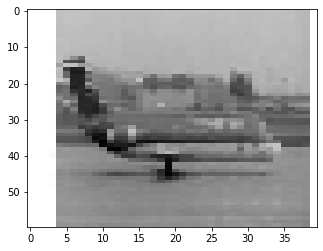

In [ ]:
display_first_as_img(caltech101_df.where(fn.col('category') == "airplanes").sample(True, 1.))

## Multilayer perceptron in SparkML

In this notebook, we will use the multilayer perceptron as a learning model. Our idea is to take the raw pixels of an image and predict the category of such an image. This is therefore a classification problem. A multilayer perceptron for classification is [available in Spark ML](http://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier).

We will focus on only three categories: airplanes, faces (easy), and motorbikes. We will split the dataset into training, validation, and testing as usual:

In [ ]:
training_df, validation_df, testing_df = caltech101_df.\
    where(fn.col('category').isin(['airplanes', 'Faces_easy', 'Motorbikes'])).\
    randomSplit([0.6, 0.2, 0.2], seed=0)

In [ ]:
[training_df.count(), validation_df.count(), testing_df.count()]

[1199, 404, 430]

It is important to check the distribution of cateogires in the validation and testing dataframes to see if they have a similar distribution as the training dataset:

In [ ]:
validation_df.groupBy('category').agg(fn.count('*')).show()
testing_df.groupBy('category').agg(fn.count('*')).show()

+----------+--------+
|  category|count(1)|
+----------+--------+
|Motorbikes|     154|
|Faces_easy|      79|
| airplanes|     171|
+----------+--------+

+----------+--------+
|  category|count(1)|
+----------+--------+
|Motorbikes|     183|
|Faces_easy|      86|
| airplanes|     161|
+----------+--------+



They are similar.

## Transforming string labels into numerical labels

To use a multilayer perceptron, we first need to transform the input data to be fitted by Spark ML. One of the things that Spark ML needs is a numerical representation of the category (`label` as they call it). In our case, we only have a string representation of such category. The [`StringIndexer`](http://spark.apache.org/docs/latest/ml-features.html#stringindexer) is used to convert the labels to numeric categories.

We first need to fit the estimator to the data so that it learns the distribution of labels:

In [ ]:
from pyspark.ml import feature

In [ ]:
category_to_number_model = feature.StringIndexer(inputCol='category', outputCol='label').\
    fit(training_df)

In [ ]:
category_to_number_model.transform(training_df).show()

+----------+--------------+--------------------+-----+
|  category|      filename|          raw_pixels|label|
+----------+--------------+--------------------+-----+
|Faces_easy|image_0002.jpg|[132.0,54.0,127.0...|  2.0|
|Faces_easy|image_0003.jpg|[251.0,250.0,250....|  2.0|
|Faces_easy|image_0004.jpg|[56.0,84.0,54.0,5...|  2.0|
|Faces_easy|image_0006.jpg|[231.0,237.0,223....|  2.0|
|Faces_easy|image_0007.jpg|[122.0,128.0,131....|  2.0|
|Faces_easy|image_0008.jpg|[32.0,64.0,65.0,6...|  2.0|
|Faces_easy|image_0010.jpg|[151.0,154.0,161....|  2.0|
|Faces_easy|image_0011.jpg|[51.0,52.0,53.0,5...|  2.0|
|Faces_easy|image_0013.jpg|[254.0,221.0,110....|  2.0|
|Faces_easy|image_0014.jpg|[149.0,150.0,156....|  2.0|
|Faces_easy|image_0015.jpg|[220.0,199.0,194....|  2.0|
|Faces_easy|image_0016.jpg|[248.0,237.0,193....|  2.0|
|Faces_easy|image_0017.jpg|[27.0,31.0,45.0,4...|  2.0|
|Faces_easy|image_0018.jpg|[152.0,155.0,153....|  2.0|
|Faces_easy|image_0020.jpg|[175.0,175.0,176....|  2.0|
|Faces_eas

Now, we can see how it transforms the category into a `label`:

There are the categories found the estimator:

In [ ]:
list(enumerate(category_to_number_model.labels))

[(0, 'airplanes'), (1, 'Motorbikes'), (2, 'Faces_easy')]

## Multi-layer perceptron

The multi-layer perceptron will take the inputs as a flattened list of pixels and it will have three output neurons, each representing a label:

In [ ]:
from pyspark.ml import classification

In [ ]:
mlp = classification.MultilayerPerceptronClassifier(seed=0).\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('raw_pixels')

The parameter `stepSize` is the learning rate for stochastic gradient descent and we set the maximum number of stochastic gradient descent epochs to 200.

Now, to define the layers, the multilayer perceptron needs to receive the number of neurons of each intermediate layer (hidden layers).

If we don't have hidden layers and the activation function is sigmoid, then the model is simply logistic regression. In this case, it will be logistic regression for multiple outputs.

For this case, the number of input neurons will be equal to the number of pixels (60*40) and the output will be equal to the categories in the dataset:

In [ ]:
mlp = mlp.setLayers([60*40, 3])

Now, we are ready to fit this simple multi-class logistic regression to the data. We need to create a pipeline that will take the training data, transform the category column, and apply the perceptron.

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
mlp_simple_model = Pipeline(stages=[category_to_number_model, mlp]).fit(training_df)

Now we can apply the model to the validation data to do some simple tests:

In [ ]:
mlp_simple_model.transform(validation_df).show(10)

+----------+--------------+--------------------+-----+--------------------+--------------------+----------+
|  category|      filename|          raw_pixels|label|       rawPrediction|         probability|prediction|
+----------+--------------+--------------------+-----+--------------------+--------------------+----------+
|Faces_easy|image_0001.jpg|[184.0,60.0,188.0...|  2.0|[-17.561090459505...|[3.37893244938922...|       2.0|
|Faces_easy|image_0005.jpg|[121.0,200.0,161....|  2.0|[-6.5146068301398...|[2.63754966385171...|       2.0|
|Faces_easy|image_0009.jpg|[166.0,170.0,166....|  2.0|[-36.337098355196...|[3.80317722927661...|       2.0|
|Faces_easy|image_0012.jpg|[237.0,239.0,238....|  2.0|[-173.34944025552...|[1.72886989296949...|       2.0|
|Faces_easy|image_0019.jpg|[101.0,102.0,99.0...|  2.0|[-44.453647914428...|[4.18407983319530...|       2.0|
|Faces_easy|image_0026.jpg|[175.0,181.0,179....|  2.0|[49.4254351346254...|[2.47444978290601...|       2.0|
|Faces_easy|image_0032.jpg|[

As we can see, the label and prediction mostly coincides.

We can be more systematic by computing the accuracy of the prediction:

In [ ]:
mlp_simple_model.transform(validation_df).select(fn.expr('avg(float(label=prediction))').alias('accuracy')).show()

+------------------+
|          accuracy|
+------------------+
|0.9257425742574258|
+------------------+



Alternatively, we can take advantage of the [evaluators shipped with Spark ML](https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html) as follows:

In [ ]:
from pyspark.ml import evaluation
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")

In [ ]:
evaluator.evaluate(mlp_simple_model.transform(validation_df))

0.9257425742574258

Which gives us the same number as before.

## More layers (warning: this will take a long time)

Now, let's see if we add one hidden layer, which adds non-linearity and interactions to the input. The definition will be similar, but we need to define how many hidden layers and how many neurons per hiden layer. This is a field of its own and we can use cross validation to see which direction is better. However, for now, we will only add one hidden layer, and play with the number of neurons.

Let's define a Multilayer Perceptron (MLP) with 1 hidden layer with 100 neurons:

In [ ]:
mlp2 = classification.MultilayerPerceptronClassifier(seed=0).\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('raw_pixels').\
    setLayers([60*40, 100, 3])

Now, __fitting this model will take significantly more time because we are adding 2 orders of magnitude more parameters than the previous model__:

In [ ]:
mlp2_model = Pipeline(stages=[category_to_number_model, mlp2]).fit(training_df)

But the model is significantly more powerful and fits the data better:

In [ ]:
evaluator.evaluate(mlp2_model.transform(validation_df))

0.9381188118811881

# Complexity of the model with more data (warning: this will take a long time)

We will evaluate how the multilayer percetron learns

Let's evaluate how the performance changes with 1) the amount of training data and 2) the number of neurons in the hidden layer

In [ ]:
evaluation_info = []

for training_size in [0.1, 0.5, 1.]:
    for n_neurons in [1, 3, 10, 20]:
        print("Training size: ", training_size, "; # Neurons: ", n_neurons)
        training_sample_df = training_df.sample(False, training_size, seed=0)
        mlp_template = classification.MultilayerPerceptronClassifier(seed=0).\
            setStepSize(0.2).\
            setMaxIter(200).\
            setFeaturesCol('raw_pixels').\
            setLayers([60*40, n_neurons, 3])
        mlp_template_model = Pipeline(stages=[category_to_number_model, mlp_template]).fit(training_sample_df)
        # append training performance
        evaluation_info.append({'dataset': 'training', 
                                'training_size': training_size,
                                'n_neurons': n_neurons,
                                'accuracy': evaluator.evaluate(mlp_template_model.transform(training_sample_df))})
        evaluation_info.append({'dataset': 'validation', 
                                'training_size': training_size,
                                'n_neurons': n_neurons,
                                'accuracy': evaluator.evaluate(mlp_template_model.transform(validation_df))})

Training size:  0.1 ; # Neurons:  1
Training size:  0.1 ; # Neurons:  3
Training size:  0.1 ; # Neurons:  10
Training size:  0.1 ; # Neurons:  20
Training size:  0.5 ; # Neurons:  1
Training size:  0.5 ; # Neurons:  3
Training size:  0.5 ; # Neurons:  10
Training size:  0.5 ; # Neurons:  20
Training size:  1.0 ; # Neurons:  1
Training size:  1.0 ; # Neurons:  3
Training size:  1.0 ; # Neurons:  10
Training size:  1.0 ; # Neurons:  20


You to understand the interaction between number of hidden layer neurons and training data size:

In [ ]:
import pandas as pd

In [ ]:
evaluation_df = pd.DataFrame(evaluation_info)
evaluation_df

,dataset,training_size,n_neurons,accuracy
0,training,0.1,1,0.383333
1,validation,0.1,1,0.381188
2,training,0.1,3,0.383333
3,validation,0.1,3,0.381188
4,training,0.1,10,0.800000
5,validation,0.1,10,0.705446
6,training,0.1,20,0.683333
7,validation,0.1,20,0.559406
8,training,0.5,1,0.718855
9,validation,0.5,1,0.742574


Plot accuracy vs. Number of Neurons

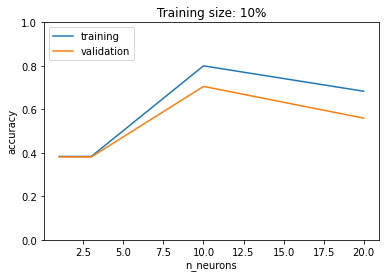

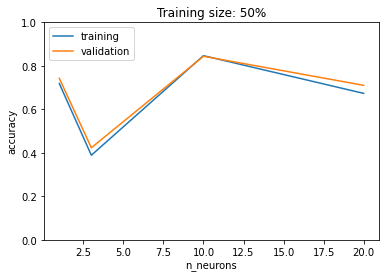

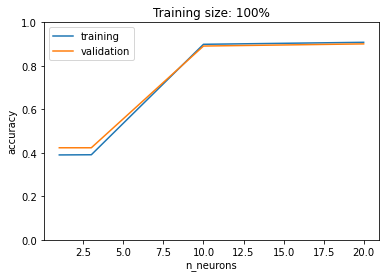

In [ ]:
for training_size in sorted(evaluation_df.training_size.unique()):
    fig, ax = plt.subplots(1, 1);
    evaluation_df.query('training_size == ' + str(training_size)).groupby(['dataset']).\
        plot(x='n_neurons', y='accuracy', ax=ax);
    plt.legend(['training', 'validation'], loc='upper left');
    plt.title('Training size: ' + str(int(training_size*100)) + '%');
    plt.ylabel('accuracy');
    plt.ylim([0, 1]);
    display()

Plot accuracy vs. training size while holding the number of neurons constant

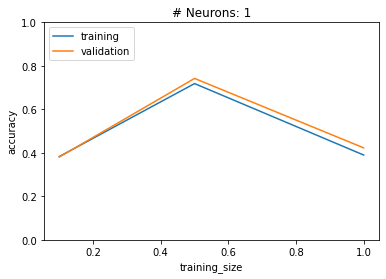

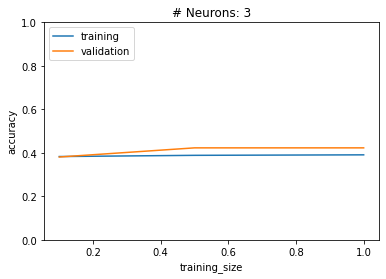

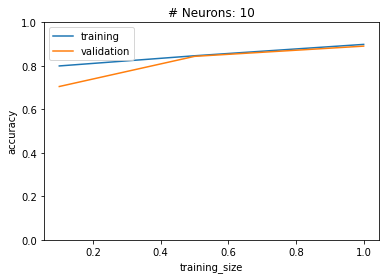

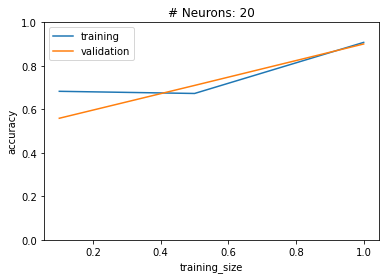

In [ ]:
for n_neurons in sorted(evaluation_df.n_neurons.unique()):
    fig, ax = plt.subplots(1, 1);
    evaluation_df.query('n_neurons == ' + str(n_neurons)).groupby(['dataset']).\
        plot(x='training_size', y='accuracy', ax=ax);
    plt.legend(['training', 'validation'], loc='upper left');
    plt.title('# Neurons: ' + str(n_neurons));
    plt.ylabel('accuracy');
    plt.ylim([0, 1]);
    display()

# Predicting on a new image downloaded from the intenet

In the following cells, uncomment the 3 different image downloads one at a time while leaving the others commented.  Run the following prediction cells to make a prediction on the new unseen random image downloaded from the internet.

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# uncomment one at a time and make a prediction

# airplane
# response = requests.get("http://images.all-free-download.com/images/graphicthumb/airplane_311727.jpg")

# face
# response = requests.get("https://www.tugraz.at/uploads/pics/Alexander_by_Kanizaj_02.jpg")

# motorbike
response = requests.get("https://www.cubomoto.co.uk/img-src/_themev2-cubomoto-1613/theme/panel-1.png")

# get the raw image data
img = Image.open(BytesIO(response.content))

We need to transform this image to grayscale and shrink it to the size that the neural network expects. We will use these steps using several packages:

Transform to grayscale:

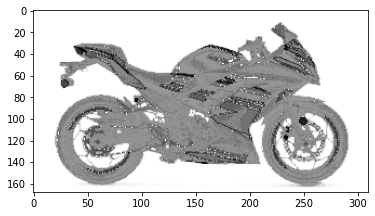

In [ ]:
# convert to grayscale
gray_img = np.array(img.convert('P'))
plt.imshow(255-gray_img, 'gray');

Shrink it to 60 by 40:

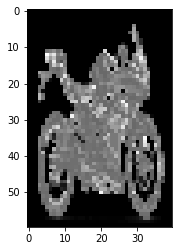

In [ ]:
shrinked_img = np.array((img.resize([40, 60]).convert('P')))
plt.imshow(shrinked_img, 'gray')
display()

Flatten it and put it in a Spark dataframe:

In [ ]:
from pyspark.ml.linalg import Vectors
new_image = shrinked_img.flatten()
new_img_df = spark.createDataFrame([[Vectors.dense(new_image)]], ['raw_pixels'])

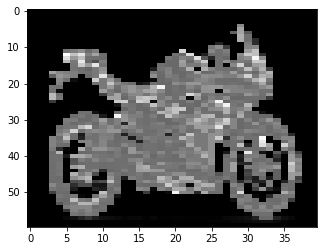

In [ ]:
display_first_as_img(new_img_df)

Now `new_img_df` has one image

In [ ]:
new_img_df.toPandas().head()

,raw_pixels
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Use the `mlp2_model` and `new_img_df` to predict the category that the new image belongs to.

In [ ]:
mlp_simple_model.transform(new_img_df).show()

+--------------------+--------------------+--------------------+----------+
|          raw_pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[0.0,0.0,0.0,0.0,...|[176.340376313439...|[1.0,5.0901126773...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [ ]:
# for reference
list(enumerate(category_to_number_model.labels))

[(0, 'airplanes'), (1, 'Motorbikes'), (2, 'Faces_easy')]